# AutoFarm - Instance Segmenation with PyTorch

As with most of my writing, I do it mainly to learn. There is an age old truth that by writing down what you learn it solidifies your understanding. So in this post, I will be implementing an instance segmentation model from scratch using the AutoFarm dataset of timelapse images of my basil crop.

This dataset is fairly straightforward. I setup a small planter box with freshly planted basil seeds and took timelapse photography of them over the course of a month as they grew. The images are not annotated, but it should be fairly easy to segment them from the background as we will see later.

The modeling is the tricky part. Instance segmentation is a complex problem when you peel back the layers of complexity that projects like [Detectron2](https://github.com/facebookresearch/detectron2) have implemented for us. It involves several models working together to produce a "instance" and "segmentation".

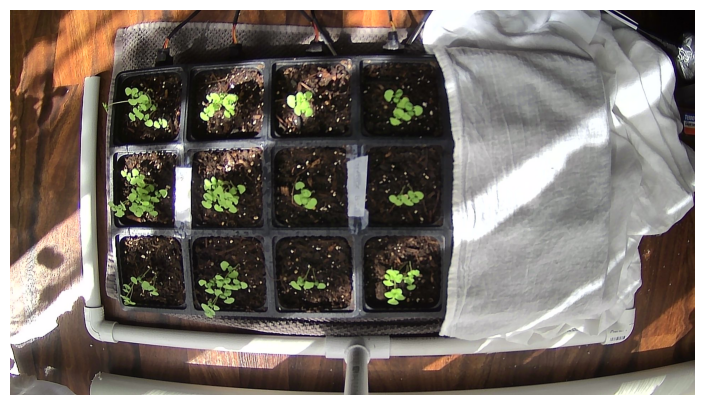

In [34]:
import matplotlib.pyplot as plt
import cv2

root_dir = '/home/jack/Mounts/DiskOne/auto_farm/raw'

capture = cv2.VideoCapture(f'{root_dir}/video_1920x1080.avi')

capture.set(cv2.CAP_PROP_POS_FRAMES, 500)

_, frame = capture.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(frame)
plt.axis('off')
plt.show()

For instance, take the Mask-RCNN architecture. It was made famous as one of the most de-facto standard models for instance segmentation for it's ability to handle a large variety of objects. But it is actually just a combination of different models working together. It has interchangeable components: a backbone model, a Region Proposal Network (RPN), a mask head, and an object detection head. These models work together to produce the final output. A really good overview of that architecture can be found here: [Understanding Mask R-CNN Basic Architecture](https://shuffleai.blog/blog/Understanding_Mask_R-CNN_Basic_Architecture.html)

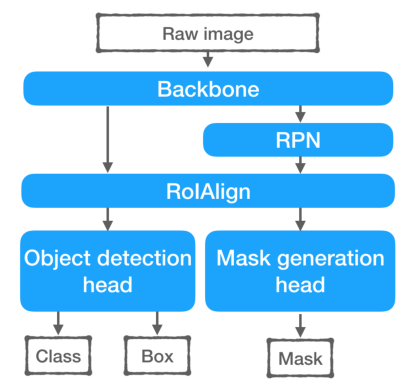

In [11]:
frame = cv2.cvtColor(cv2.imread('./maskrcnn.png'), cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.axis('off')
plt.show()

Let's start slowly by first trying to extract the basil plants from the background and build a dataset for our model. We can use a color thresholding technique to segment the plants from the background, and then find the contours to create masks for each instance of the plants.

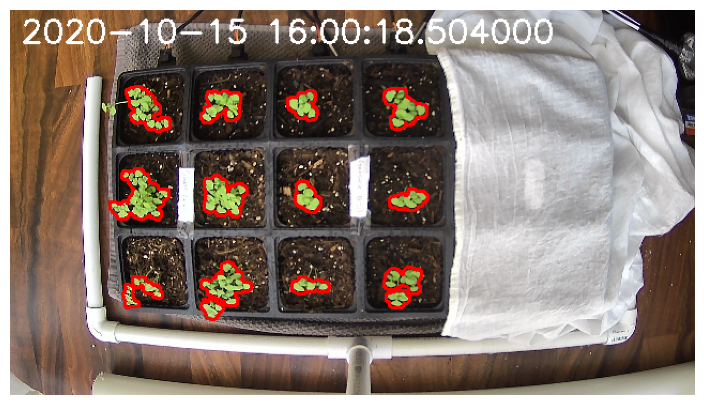

In [49]:
import json
import numpy as np
import pandas as pd

def extract_masks(resolution):
    timestamps = json.load(open(f'{root_dir}/timestamps_{resolution}.json'))
    
    capture = cv2.VideoCapture(f'{root_dir}/video_{resolution}.avi')
    capture.set(cv2.CAP_PROP_FPS, 0)
    
    # skip to frame 1000
    capture.set(cv2.CAP_PROP_POS_FRAMES, 1000)

    lower_green = np.array([[35, 40, 40]])
    upper_green = np.array([[95, 255, 255]])
    
    lower_gray = np.array([[0, 0, 0]])
    upper_gray = np.array([[200, 60, 255]])

    index = 0
    skip_index = 0

    while True:
        ret, frame = capture.read()

        if not ret:
            break

        oframe = frame.copy()
        oframe = cv2.cvtColor(oframe, cv2.COLOR_BGR2RGB)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        brightness = np.mean(frame[:, :, 2]) / 255
        
        if brightness < 0.3 or brightness > 0.7:
            continue
        
        mask = cv2.inRange(frame, lower_gray, upper_gray)
        mask = cv2.dilate(mask, (5, 5), iterations=5)
        frame = cv2.bitwise_and(frame, frame, mask=cv2.bitwise_not(mask))

        mask = cv2.inRange(frame, lower_green, upper_green)
        mask = cv2.blur(mask, (9, 9))
        mask = cv2.dilate(mask, (5, 5), iterations=2)

        contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        contours = [c for c in contours if cv2.contourArea(c) > 1500]
        
        # remove all pixels not in the contours
        neg_mask = np.zeros_like(mask)
        cv2.drawContours(neg_mask, contours, -1, 255, -1)
        mask = neg_mask
        
        # resize masks to 640x360 to save space
        scale = 640 / mask.shape[1]
        mask = cv2.resize(mask, (640, 360))
        oframe = cv2.resize(oframe, (640, 360))
        for contour in contours:
            contour[:, :, 0] = (contour[:, :, 0] * scale).astype(np.int32)
            contour[:, :, 1] = (contour[:, :, 1] * scale).astype(np.int32)
        
        timestamp = timestamps[index]
        
        yield timestamp, mask, contours, oframe
        
        skip = skip_index * 100
        capture.set(cv2.CAP_PROP_POS_FRAMES, skip)
        
        index = skip
        skip_index += 1

    capture.release()
    
    
for timestamp, mask, contours, frame in extract_masks('1920x1080'):

    for contour in contours:
        cv2.drawContours(frame, [contour], -1, (255, 0, 0), 2)
    
    timestamp = pd.to_datetime(timestamp, unit='ms')
    cv2.putText(frame, str(timestamp), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # cv2.imshow('frame', frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break
    
    plt.figure(figsize=(10, 5))
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    break

Our thresholding technique worked pretty well without the need for any complex instance segmentation model. Plus it runs in real-time on a CPU! But, where is the fun in that? From here, we can save the frames, and then create a dataset formatted for training our model. We won't try to annotate the images by hand, we will just "trust" that our thresholding technique is good enough to segment the plants from the background. Let's do that now.

In [50]:
import os
import json

output_dir = '/home/jack/Mounts/DiskOne/auto_farm/dataset'

os.makedirs(f'{output_dir}', exist_ok=True)

coco_data = {
    'images': [],
    'annotations': [],
    'categories': [
        { 'id': 1, 'name': 'crop' }
    ],
}

for resolution in ['1920x1080', '1280x720']:

    for timestamp, mask, contours, frame in extract_masks(resolution):
        
        frame_path = f'{output_dir}/{timestamp}.png'
        
        cv2.imwrite(frame_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        
        coco_data['images'].append({
            'id': len(coco_data['images']),
            'file_name': frame_path,
            'width': mask.shape[1],
            'height': mask.shape[0],
        })
        
        for contour in contours:
            bbox = cv2.boundingRect(contour)
            area = cv2.contourArea(contour)
            segmentation = [contour.flatten().tolist()]
            
            coco_data['annotations'].append({
                'id': len(coco_data['annotations']),
                'image_id': len(coco_data['images']) - 1,
                'category_id': 1,
                'segmentation': segmentation,
                'area': area,
                'bbox': bbox,
                'iscrowd': 0,
            })

with open(f'{output_dir}/coco.json', 'w') as f:
    json.dump(coco_data, f)

In [52]:
len(coco_data['images']), len(coco_data['annotations'])

(476, 5214)

Awesome! We now have a COCO formatted data that we completely automated. Around 500 images boasting 4200 annotations. This is a good start for training the model. I won't begin to explain the inaccuracies of this dataset, but as this is just a learning exercise, it should be good enough to get us started.

Now when we create this model, we don't nessesarily have to recreate the entire ResNet architecture, or implement a Region Proposal Network. This is much too tedious and unnessesary. We can use pre-trained models from the pytorch library to help us get started. In fact, Pytorch already has a pre-trained model for MaskRCNN that we can use. We just have to set it up to work with our dataset, and train it!

In [5]:
import torch as t
import torch.nn as nn
import torchvision as tv

from torchmetrics.segmentation import MeanIoU
from torchmetrics.detection.mean_ap import MeanAveragePrecision


class MaskRCNN(nn.Module):
    
    def __init__(self):
        super(MaskRCNN, self).__init__()
        self.gpu = t.cuda.is_available()
        self.model = tv.models.detection.maskrcnn_resnet50_fpn_v2(weights=None, progress=True, num_classes=1)
        if self.gpu:
            self.model = self.model.float().cuda()


    def forward(self, x):
        return self.model(x['image'], x['targets'])
    
    
    def validate(self, dataset, batch_size=1):
        metrics = {
            'mean_iou': MeanIoU(num_classes=1),
            'box_ap': MeanAveragePrecision(box_format='xywh', iou_type='bbox'),
            'mask_ap': MeanAveragePrecision(iou_type='segm'),
        }
        
        self.model.eval()
        
        for i in range(0, len(dataset['image']), batch_size):
            images = dataset['image'][i:i+batch_size]
            targets = dataset['targets'][i:i+batch_size]
            
            if self.gpu:
                images = t.stack(images).cuda()
        
            output = self.model(images)
            
            for index in range(len(targets)):
                masks = output[index]['masks'].squeeze()
                scores = output[index]['scores']
                boxes = output[index]['boxes']
                labels = output[index]['labels']

                print(scores)



    def train(
        self,
        dataset=None,
        learning_rate=0.001,
        epochs=1000,
        val_epochs=10,
        test_split=0.2,
        val_split=0.1,
        batch_size=1,
    ):
        optimizer = t.optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = t.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
        
        train_dataset = dataset['image'][:int(len(dataset['image']) * (1 - test_split - val_split))]
        val_dataset = dataset['image'][len(train_dataset):int(len(dataset['image']) * (1 - test_split))]
        test_dataset = dataset['image'][len(train_dataset) + len(val_dataset):]
        
        print(f'Training on {len(train_dataset)} samples')
        print(f'Validating on {len(val_dataset)} samples')
        print(f'Testing on {len(test_dataset)} samples')
    
        with t.autograd.set_detect_anomaly(False):
            val_index = 0
            for epoch in range(epochs):
                val_index += 1
                
                self.model.train()
                
                for i in range(0, len(train_dataset['image']), batch_size):
                    images = train_dataset['image'][i:i+batch_size]
                    targets = train_dataset['targets'][i:i+batch_size]
                    
                    if self.gpu:
                        images = t.stack(images).cuda()
                        targets = [{k: t.tensor(v).cuda() for k, v in target.items()} for target in targets]
                    
                    optimizer.zero_grad()
                    loss = self.model(images, targets)
                    
                    total_loss = sum(loss.values())
                    total_loss.backward()
                    optimizer.step()
                    
                print(f'Epoch {epoch+1}/{epochs} - Loss: {total_loss.item()}')
                    
                scheduler.step()
                
                if val_index == val_epochs:
                    val_index = 0
                    self.validate(val_dataset, batch_size)


model = MaskRCNN()

image = t.rand(3, 480, 640)
targets = {
    'masks': t.rand(1, 480, 640),
    'labels': t.tensor([0]).to(t.int64),
    'boxes': t.tensor([[0, 0, 100, 200]])
}

dataset = {'image': [], 'targets': []}
for _ in range(5):
    dataset['image'].append(image)
    dataset['targets'].append(targets)

model.train(dataset, epochs=10, batch_size=2, val_epochs=1)

Training on 3 samples
Validating on 1 samples
Testing on 1 samples


TypeError: list indices must be integers or slices, not str

The code is documented for reference. Again most of these things, like the optimizer, scheduler, batching algorithm, and the Pytorch logistics is hitten to us in packages like Detectron2. Even in Pytorch's Mask-RCNN network, there is a huge hidden amount of information about the network that we don't have to burden ourselves with. But, since this took around 7 minutes on my CPU for 10 epochs of a very small dataset, we are going to need to optimize this model.

For one, we have to utilize the GPU. I actually don't have an NVIDIA GPU or a compatible AMD GPU on my machine, so I have to SSH into my other machine to run this.

Secondly, this dataset will not fit into memory. We will need to implement a dataloader for this. This should be fairly straightforward however.

Finally, we don't need to train the entire network. We can utilize pretrained weights from the COCO dataset to help us get started. Then, we can freeze the weights of the backbone network and only train the mask head and the object detection head. This should help us get started.